In [ ]:
!ssh -NL localhost:6072:lsf-server-2:6072 kaindl @ rostssh

In [126]:
from pathlib import Path

import tqdm
import json
import pandas as pd

import seaborn as sns

In [2]:
!which python

/mnt/lsf-nas-1/os-shared/anaconda3/envs/kaindl_ppi/bin/python


In [97]:
mh_dir = Path('/mnt/home/mheinzinger/deepppi1tb/'
              'collabfold/leo_ppi_huri_test/')
ppi_dir = Path('/mnt/project/kaindl/ppi/ppi_data/v2.1')
chunks = list(range(1, 6))
# chunks = [2]
mh_dir.is_dir(), ppi_dir.is_dir(), chunks

(True, True, [1, 2, 3, 4, 5])

In [98]:
mapping = list()

for chunk in chunks:
    cd = dict()
    for a3m in tqdm.tqdm(list(
            (mh_dir / f'results_chunk_{chunk}').glob('*.a3m')),
            desc=f'chunk_{chunk}'):
        query = int(a3m.stem)
        with a3m.open('r') as msa:
            assert msa.readline().strip().startswith('#')
            ida, idb = msa.readline().strip(
            )[1:].split('\t')[0].split('_')
            cd[query] = ida, idb

    cd = pd.DataFrame.from_dict(cd, orient='index',
                                columns=['ida', 'idb']).reset_index()
    cd['chunk'] = chunk

    mapping.append(cd)
mapping = pd.concat(mapping)
mapping

chunk_5: 100%|██████████| 250/250 [00:00<00:00, 414.02it/s]


,index,ida,idb,chunk
0,328,CRC-EA0B02C83F3B6BF3,CRC-F80F0502B3B3838A,1
1,167,CRC-86B3616504B05B7E,CRC-DF5A7DB1E4126063,1
2,270,CRC-B39AC1F4D619570F,CRC-C0961E2BE50B24DF,1
3,37,CRC-4EFC3AF5D5BBABD3,CRC-C14CD8B937A7B6E8,1
4,30,CRC-4D56F5FD983211A6,CRC-521C53F367A3A29E,1
...,...,...,...,...
245,59,CRC-0D2C93B1D54EB09A,CRC-4D56F5FD983211A6,5
246,88,CRC-17999B7FDD3C6A52,CRC-C4E47E9313BB47B5,5
247,108,CRC-1AE2FAE62D2B28C6,CRC-63D09D927D452FCC,5
248,174,CRC-2673C9DDD3C176E4,CRC-8A380144441AEA33,5


In [99]:
pairs = pd.read_csv(
    ppi_dir / '1:1_small' / 'huri_test.tsv', sep='\t')[
    ['hash_A', 'hash_B', 'label']].rename(columns=dict(
    hash_A='ida', hash_B='idb'))
pairs.head()

,ida,idb,label
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,1
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,1
2,CRC-001576EA78C61C85,CRC-2743716544288776,1
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,1
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,1


In [100]:
mp = pd.merge(mapping, pairs, on=['ida', 'idb'])
mp

,index,ida,idb,chunk,label
0,328,CRC-EA0B02C83F3B6BF3,CRC-F80F0502B3B3838A,1,0
1,167,CRC-86B3616504B05B7E,CRC-DF5A7DB1E4126063,1,0
2,270,CRC-B39AC1F4D619570F,CRC-C0961E2BE50B24DF,1,0
3,37,CRC-4EFC3AF5D5BBABD3,CRC-C14CD8B937A7B6E8,1,0
4,30,CRC-4D56F5FD983211A6,CRC-521C53F367A3A29E,1,0
...,...,...,...,...,...
1327,59,CRC-0D2C93B1D54EB09A,CRC-4D56F5FD983211A6,5,1
1328,88,CRC-17999B7FDD3C6A52,CRC-C4E47E9313BB47B5,5,1
1329,108,CRC-1AE2FAE62D2B28C6,CRC-63D09D927D452FCC,5,1
1330,174,CRC-2673C9DDD3C176E4,CRC-8A380144441AEA33,5,1


In [101]:
scores = list()

for chunk in chunks:
    sd = dict()
    for f in tqdm.tqdm(list(
            (mh_dir / f'results_chunk_{chunk}/predictions'
            ).glob('*_unrelaxed_rank_1_model_*.json')),
            desc=f'chunk_{chunk}'):
        query, *_, model, _ = f.stem.split('_')
        with open(f, 'r') as json_file:
            js = json.load(json_file)

        sd[int(query)] = int(model), js['ptm'], js['iptm']

    sd = pd.DataFrame.from_dict(
        sd, orient='index',
        columns=['model', 'ptm', 'iptm']).reset_index()
    sd['chunk'] = chunk

    scores.append(sd)
scores = pd.concat(scores)
scores

chunk_5: 100%|██████████| 146/146 [00:05<00:00, 25.16it/s]


,index,model,ptm,iptm,chunk
0,39,1,0.34,0.22,1
1,203,2,0.49,0.63,1
2,282,5,0.65,0.19,1
3,75,1,0.50,0.13,1
4,306,1,0.24,0.16,1
...,...,...,...,...,...
141,171,1,0.25,0.11,5
142,189,1,0.26,0.12,5
143,207,3,0.59,0.19,5
144,188,3,0.45,0.29,5


In [102]:
ov = pd.merge(mp, scores, on=['index', 'chunk'])
ov

,index,ida,idb,chunk,label,model,ptm,iptm
0,167,CRC-86B3616504B05B7E,CRC-DF5A7DB1E4126063,1,0,5,0.28,0.13
1,160,CRC-8467F2B515681CCA,CRC-B89D59E8118684A3,1,0,1,0.30,0.36
2,277,CRC-B7D1FE64F242B25A,CRC-DB18B8F3FABFBAF6,1,0,2,0.26,0.12
3,112,CRC-70F6C604E9E26662,CRC-7183BF01D2D7D069,1,0,3,0.43,0.11
4,205,CRC-95DCD6FAEED621E6,CRC-D33DF6D5354C6A58,1,0,5,0.41,0.23
...,...,...,...,...,...,...,...,...
960,57,CRC-0CC610356D4AA040,CRC-7183BF01D2D7D069,5,1,4,0.27,0.21
961,218,CRC-2CBB21C35AF9623A,CRC-C26A21E33C60AA78,5,1,4,0.27,0.27
962,88,CRC-17999B7FDD3C6A52,CRC-C4E47E9313BB47B5,5,1,1,0.23,0.12
963,174,CRC-2673C9DDD3C176E4,CRC-8A380144441AEA33,5,1,4,0.25,0.27


In [144]:
ov.sort_values(by='iptm', ascending=False)

,index,ida,idb,chunk,label,model,ptm,iptm
789,36,CRC-35B3171253CC69CF,CRC-B0DA1FC8FA6B766A,4,1,3,0.82,0.90
899,91,CRC-17ACB540FD5B975B,CRC-5B070FE11D78D0A4,5,1,3,0.50,0.88
518,61,CRC-9DE436A7FF533443,CRC-B2ED164C9F379EDD,3,1,2,0.86,0.88
840,94,CRC-17ACB540FD5B975B,CRC-DC3E535979396B67,5,1,4,0.42,0.88
955,211,CRC-2CBB21C35AF9623A,CRC-56BE16322D749904,5,1,5,0.58,0.87
...,...,...,...,...,...,...,...,...
739,9,CRC-324AD76EA1165C44,CRC-47C45EA0BB722E09,4,1,2,0.22,0.07
704,102,CRC-4954E7F712A87BBE,CRC-B1163143D1292259,4,1,2,0.10,0.07
28,3,CRC-44AD1817D6C536D6,CRC-B62134DD1BEB636B,1,0,4,0.30,0.07
653,242,CRC-817752F20E262FD3,CRC-EF419358B7977E36,4,1,1,0.40,0.07


In [104]:
ov.label.value_counts()

0    514
1    451
Name: label, dtype: int64

In [105]:
ov.iptm.describe()

count    965.000000
mean       0.230684
std        0.144230
min        0.060000
25%        0.140000
50%        0.180000
75%        0.270000
max        0.900000
Name: iptm, dtype: float64

In [106]:
ov.iptm.corr(ov.label, method='spearman')

0.08316145744563654

In [141]:
ov.ptm.corr(ov.label, method='spearman')

0.058638128981772904

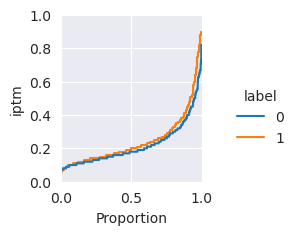

In [135]:
g = sns.displot(data=ov,
                y='iptm',
                hue='label',
                kind='ecdf',
                height=2.4,
                )
g.set(xlim=(0, 1), ylim=(0, 1))

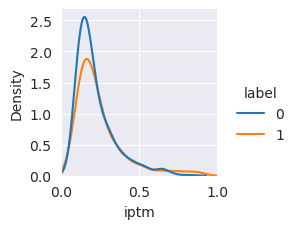

In [137]:
g = sns.displot(data=ov,
                x='iptm',
                hue='label',
                height=2.4,
                kind='kde',
                # kind='hist',
                # stat='density',
                # bins=25,
                )
g.set(xlim=(0, 1))

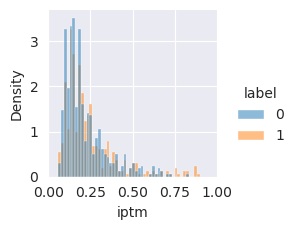

In [146]:
g = sns.displot(data=ov,
                x='iptm',
                hue='label',
                height=2.4,
                # kind='kde',
                kind='hist',
                stat='density',
                bins=50,
                )
g.set(xlim=(0, 1))

In [152]:
ev = ov.loc[ov.iptm > .5].copy()
ev.iptm.corr(ev.label, method='spearman')

0.16242097937173566